In [2]:
import numpy as np
import numpy as np
from itertools import permutations
import random
import matplotlib.pyplot as plt


# $\epsilon$-Greedy Algorithm | simoultaneous offers 

In [3]:
T = 100000
epsilon_0 = 0.01
eta = 0.05

## Agents' Initialization
## 5 agents in total, no sex distinction, true values 
N = 6     # Number of Agents 

epsilon_0 = 0.5  # initial probability of exploration
K = np.zeros(N)                                     

# Mean and std deviation of the noise signals (sampled form a std Normal )
noise_mean = 0 
noise_std = 0.5

In [4]:
## Initialization prior beliefs matrix 
## consistent with the priors of thompson sampling,
## we use identical initialization -- (no prior knowledge) and  0 values on the diagonal

np.random.seed(25)
Q = 0.5*np.ones((N, N))
np.fill_diagonal(Q, 0)  

In [5]:
## Initialization prior beliefs of being accepted probailities matrix
np.random.seed(25)
p = np.random.uniform(0, 1, size=(N, N))
np.fill_diagonal(p, 1)  

In [25]:
v = np.random.uniform(0, 0.99, (6,6))
N = 6       # Number of Agents 
np.fill_diagonal(v, 0)

v[0,1] = 1
v[1,0] = 1

v[2, 3] = 1
v[3,2] = 1

v[4,5] = 1
v[5,4] = 1


In [6]:
def greedy_proposal(i, Q , p ):
    '''This function returns the the index of agents to propose 
    under the greedy approach, for agent i '''
    q = np.array(Q[i])
    p_i = np.array(p[i])

    return np.argmax(p_i*q)

In [8]:
def invert_offers(offers):
    ' function to invert the offers being made '
    inverted_offers = {}
    for proposer, recipient in offers.items():
        inverted_offers.setdefault(recipient, []).append(proposer)
    return inverted_offers

In [9]:
def greedy_decision(i, offers, Q):
    'Function that decides wich to accept the offer to greedy decision'

    q = np.array(Q[i, offers])
    return offers[np.argmax(q)]

In [54]:
def initialize_value_matrix(N):
    # Create an NxN matrix with random values between 5 and 9
    matrix = np.random.uniform(0, 0.5, (N, N))
    matrix = (matrix + matrix.T) / 2
    
    # Fill the diagonal with 0
    np.fill_diagonal(matrix, 0)
    
    # Set specific symmetric pairs to 1
    for i in range(0, N, 2):
        if i+1 < N:
            matrix[i, i+1] = 1
            matrix[i+1, i] = 1
    
    return matrix

In [11]:
def initialize_prior_Q(N):
    'Initializes the prior values probabilities -- No information uniform initialization'
    # Q = 0.5*np.ones((N, N))
    # np.fill_diagonal(Q, 0)  
    
    Q = np.random.uniform(0, 1, size=(N, N))
    np.fill_diagonal(Q, 0) 

    return Q


In [12]:
def initialize_prior_p(N):
    'Initializes the prior probabilities p  of being accepted -- No information 0.5 initialization'

    # p = np.ones((N, N))
    # np.fill_diagonal(p, 1) 
    p = np.random.uniform(0, 1, size=(N, N))
    np.fill_diagonal(p, 1)  
    return p

In [13]:
def observed_pairs(matrix):
    ' Given the binary allocation matrix returns the true observed pairings '
    n = len(matrix)
    result = []
    for i in range(n):
        for j in range(i+1, n):
            if matrix[i][j] == 1 and matrix[j][i] == 1:
                result.append((i, j))
    return result

In [25]:
random.random()

0.5882560002003425

In [32]:
0.2**(1/10000)

0.9998390691595138

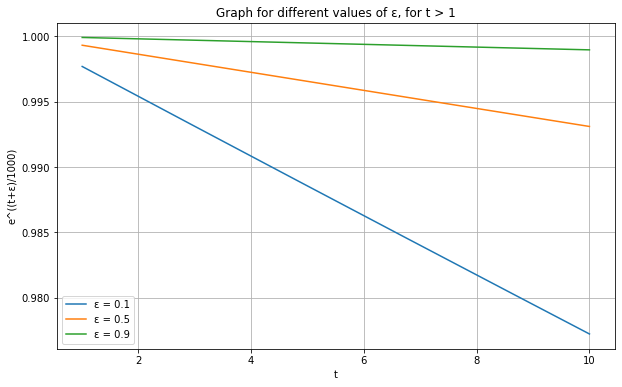

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range for t (t > 1)
t = np.linspace(1.01, 10, 500)  # You can adjust the upper limit as needed

# Define the different values of epsilon (ε) to plot
epsilons = [0.1, 0.5, 0.9]

# Plot the graph for each value of epsilon
plt.figure(figsize=(10, 6))
for epsilon in epsilons:
    y = epsilon**(t/1000) # Using the given function with different values of epsilon
    plt.plot(t, y, label=f'ε = {epsilon}')

# Customize the plot
plt.title('Graph for different values of ε, for t > 1')
plt.xlabel('t')
plt.ylabel('e^((t+ε)/1000)')
plt.legend()
plt.grid(True)
plt.show()


In [110]:
def epsilon_greedy(T, N, e = epsilon_0, eta = 0.05):

    v = initialize_value_matrix(N)      # True values
    Q = initialize_prior_Q(N)           # prior of values
    p = initialize_prior_p(N)           # prior of probabilities 

    print(v)
    print(Q)
    print(p)

    ## stable matchings set 
    stable_matching = set((x-1,x) for x in range(1, N, 2))
    n_stable_couples = []
    tau = []

    for t in range(T): 

        ## Proposal phase 
        offers = {}
        epsilon = e**((t+1)/1000)
        #print(epsilon)

        for i in range(N):
            if random.random() < epsilon:
                #print('I am exploriing')
            # Exploration: with probability epsilon
                offers[i] = random.choice(list(range(N)))
               # print(offers)
                
            else:
            # Greedy: with the remaining probability (1 - epsilon)
                #print(' I am NOT exploring ')
                offers[i] = greedy_proposal(i, Q, p)
               # print(offers)


        #print('offers \n')
        #print(offers)
            
        ## Acceptance phase
        offers_recievers = invert_offers(offers)
        m_matrix = np.zeros((N, N)) 

        for j in offers_recievers.keys():
            max_index = greedy_decision(j, offers_recievers[j], Q)
            m_matrix[j, max_index] = 1

        #print('proposed offers\n')
        #print(m_matrix)

        #print('observed_pairs\n')
        #print(observed_pairs(m_matrix))
        
        
        tau.append(1 if set(observed_pairs(m_matrix)) == stable_matching else 0 )

        ## Updates 
        for i in range(N):
            for j in range(N):
                if (m_matrix[i, j] == 1) and (m_matrix[j, i] ==1):
                    #print(f'updated match {i} and {j} \n')
                    ## Update the Q of the observed value - if matches take place
                    Q[i, j] =  Q[i, j]/2 +  (v[i, j])/2#(+ np.random.normal(noise_mean, noise_std, 1))/2 
                    ## update the probability of being accepted 
                    p[i, j] = (1-eta)*p[i, j] + eta 
                    #if tau[-1] ==1:
                        #print(Q[i, j])

                elif (m_matrix[i, j] == 1) and (m_matrix[j, i] ==0) :
                    ## update the probability of not being accepted
                    p[i, j] = (1-eta)*p[i, j] 



        n_stable_couples.append(len( set(observed_pairs(m_matrix)) & stable_matching ))

    return observed_pairs(m_matrix), n_stable_couples, tau, Q, p


In [111]:
z, n, t, Q, p= epsilon_greedy(1000, 6, e = 0.1) 

[[0.         1.         0.46343194 0.2786064  0.31716835 0.24848855]
 [1.         0.         0.14802398 0.4049794  0.12970362 0.38734273]
 [0.46343194 0.14802398 0.         1.         0.32234589 0.18565632]
 [0.2786064  0.4049794  1.         0.         0.10552205 0.27513003]
 [0.31716835 0.12970362 0.32234589 0.10552205 0.         1.        ]
 [0.24848855 0.38734273 0.18565632 0.27513003 1.         0.        ]]
[[0.         0.60034971 0.52824908 0.15748884 0.50640344 0.73940174]
 [0.78493454 0.         0.16380831 0.57239984 0.34009422 0.60478103]
 [0.2735754  0.78038084 0.         0.71014675 0.57478918 0.59854531]
 [0.16478523 0.16349703 0.97046641 0.         0.58166817 0.9438954 ]
 [0.47226959 0.3441137  0.60643782 0.03388343 0.         0.82156756]
 [0.19623779 0.47634084 0.71602132 0.83155704 0.09684745 0.        ]]
[[1.         0.15054557 0.64383345 0.95859023 0.14210203 0.05247163]
 [0.54638068 1.         0.73739163 0.71740482 0.8081236  0.37695218]
 [0.22747451 0.28971314 1.      

<Axes: >

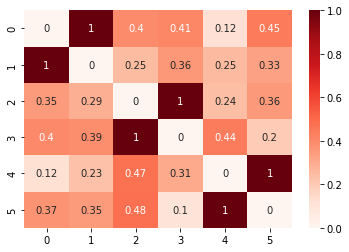

In [106]:
sns.heatmap(Q, annot=True, cmap='Reds', cbar=True)


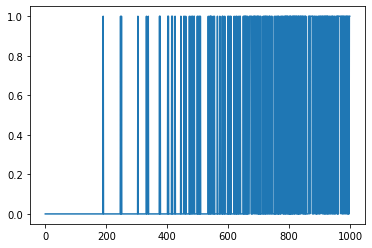

In [109]:
plt.plot(t)

In [101]:
z

[(0, 1), (2, 3)]

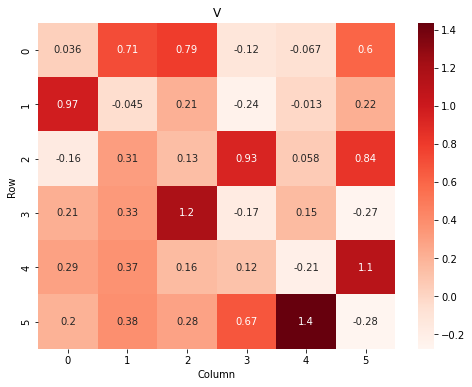

In [83]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



# Create the heatmap with the Reds colormap
plt.figure(figsize=(8, 6))
sns.heatmap(Q, annot=True, cmap='Reds', cbar=True)

# Add title and labels
plt.title('V')
plt.xlabel('Column')
plt.ylabel('Row')

# Display the heatmap
plt.show()


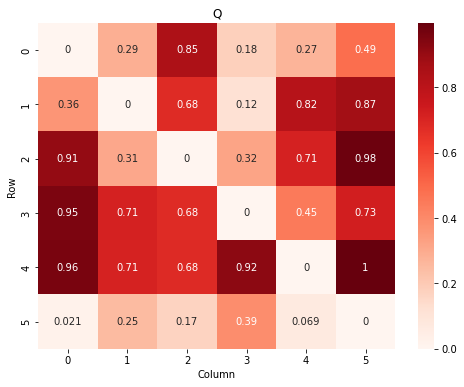

In [64]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the matrix
matrix = np.array([
    [0.0, 0.28767282, 0.84543039, 0.1797949, 0.27278892, 0.48713448],
    [0.36316465, 0.0, 0.68078644, 0.1192458, 0.81603451, 0.87469652],
    [0.90750509, 0.30845137, 0.0, 0.32081907, 0.7142927, 0.98479464],
    [0.95285358, 0.71367811, 0.67854324, 0.0, 0.4484907, 0.72865508],
    [0.96220225, 0.7128187, 0.68376056, 0.92190647, 0.0, 0.99773147],
    [0.02147723, 0.25153542, 0.16784528, 0.3901169, 0.06909985, 0.0]
])

# Create the heatmap with the Reds colormap
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, cmap='Reds', cbar=True)

# Add title and labels
plt.title('Q')
plt.xlabel('Column')
plt.ylabel('Row')

# Display the heatmap
plt.show()


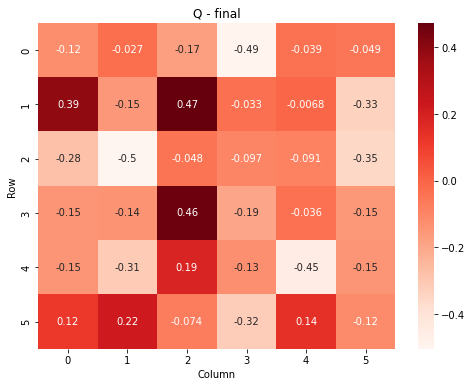

In [67]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create the heatmap with the Reds colormap
plt.figure(figsize=(8, 6))
sns.heatmap(Q, annot=True, cmap='Reds', cbar=True)

# Add title and labels
plt.title('Q - final')
plt.xlabel('Column')
plt.ylabel('Row')

# Display the heatmap
plt.show()

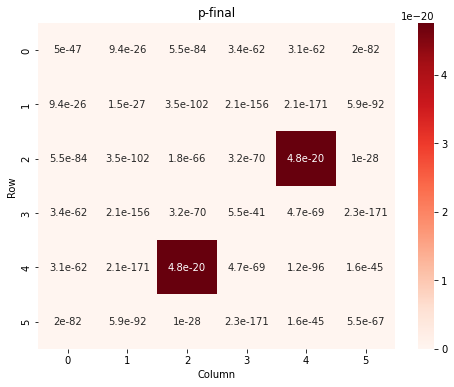

In [68]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Create the heatmap with the Reds colormap
plt.figure(figsize=(8, 6))
sns.heatmap(p, annot=True, cmap='Reds', cbar=True)

# Add title and labels
plt.title('p-final')
plt.xlabel('Column')
plt.ylabel('Row')

# Display the heatmap
plt.show()


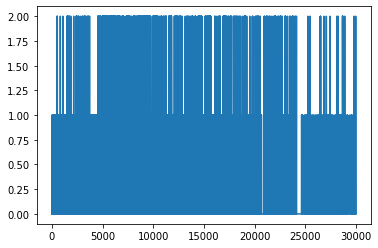

In [46]:
plt.plot(n)

In [121]:
rounds = 100
N_agents = np.arange(6, 20, 2)

In [122]:
result_simulation = {key: 0 for key in N_agents}
T = 10000
for a in N_agents:
    for n in range(rounds): 

        #stable_matching = [(i, i+1) for i in range(0, a, 2)]
        matching, n, t  = epsilon_greedy(T, a)
    
        if  t[-1] == 1: 
            result_simulation[a] += 1 

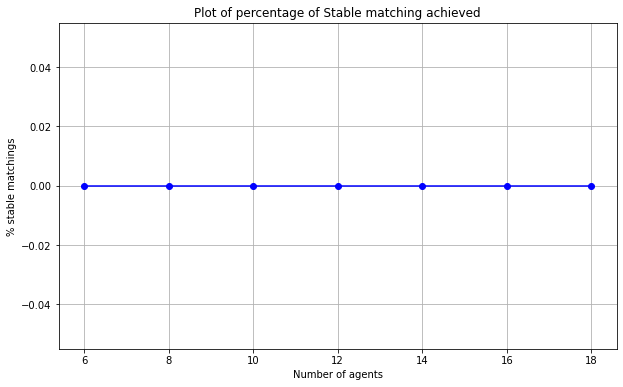

In [123]:
import matplotlib.pyplot as plt

# Provided dictionary

plt.figure(figsize=(10, 6))

plt.plot(result_simulation.keys(), result_simulation.values(), marker='o', linestyle='-', color='blue')
plt.xlabel('Number of agents')
plt.ylabel('% stable matchings')
plt.title('Plot of percentage of Stable matching achieved')
plt.grid(True)
plt.show()

## $\epsilon$- variants simulations -- Das Kamenica paper 

In [124]:
result_simulation_eps = {key: 0 for key in N_agents}
eps_values = np.linspace(0.1, 1, 10)
T = 10000

for e  in eps_values:
    for n in range(rounds): 

        matching, n, t  = epsilon_greedy(T, 8, e)
    
        if  t[-1] == 1: 
            result_simulation_eps[e] += 1 

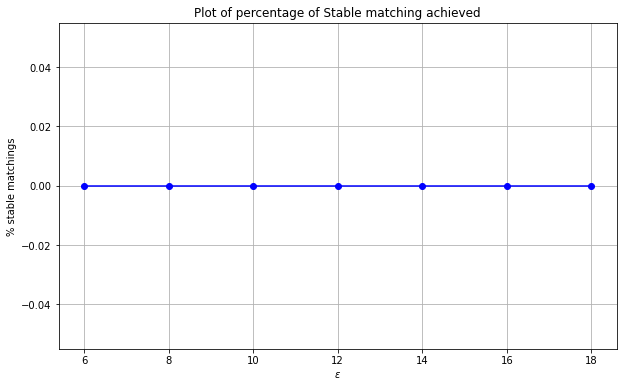

In [125]:
plt.figure(figsize=(10, 6))

plt.plot(result_simulation_eps.keys(), result_simulation_eps.values(), marker='o', linestyle='-', color='blue')
plt.xlabel('$\epsilon$')
plt.ylabel('% stable matchings')
plt.title('Plot of percentage of Stable matching achieved')
plt.grid(True)
plt.show()

## $\epsilon$-Greedy no probabilities

In [143]:
def epsilon_greedy_no_prob(T, N, e = epsilon_0, eta = eta):

    v = initialize_value_matrix(N)      # True values
    Q = initialize_prior_Q(N)           # prior of values
    p = initialize_prior_p(N)           # prior of probabilities 

    ## stable matchings set 

    stable_matching = set((x-1,x) for x in range(1, N, 2))
    n_stable_couples = []
    tau = []


    for t in range(T): 

        ## Proposal phase 
        offers = {}
        epsilon = e**(t/1000)

        for i in range(N):
            if random.random() < epsilon:
            # Exploration: with probability epsilon
                offers[i] = random.choice(list(range(N)))
            else:
            # Greedy: with the remaining probability (1 - epsilon)
                offers[i] = np.argmax(Q[i])
            

        ## Acceptance phase
        offers_recievers = invert_offers(offers)
        m_matrix = np.zeros((N, N)) 

        for j in offers_recievers.keys():
            max_index = greedy_decision(j, offers_recievers[j], Q)
            m_matrix[j, max_index] = 1

        ## Updates 
        for i in range(N):
            for j in range(N):
                if (m_matrix[i, j] == 1) and (m_matrix[j, i] ==1):
                    ## Update the Q of the observed value - if matches take place

                    Q[i, j] =  Q[i, j]/2 +  (v[i, j]/2 + np.random.normal(noise_mean, noise_std, 1))/2 
                    ## update the probability of being accepted 
                    #p[i, j] = (1-eta)*p[i, j] + eta 

                #else:
                    ## update the probability of not being accepted
                    #p[i, k] = (1-eta)*p[i, k] 

        n_stable_couples.append(len( set(observed_pairs(m_matrix)) & stable_matching ))
        tau.append(1 if set(observed_pairs(m_matrix)) == stable_matching else 0 )

    return observed_pairs(m_matrix), n_stable_couples, tau


In [155]:
m, n, t = epsilon_greedy_no_prob(1000, 4)

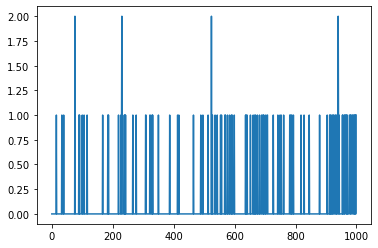

In [156]:
plt.plot(n)

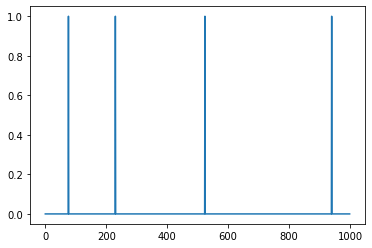

In [157]:
plt.plot(t)